# Libraries Import

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

df = pd.read_csv("../data/filter_dataset.csv")

# Training the BERT Classification Model

In [ ]:
df = df[['Essay', 'Overall']].dropna()
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Essay'].tolist(), df['Overall'].tolist(), test_size=0.2, random_state=42
)

#Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EssayDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_texts, train_labels, tokenizer)
test_dataset = EssayDataset(test_texts, test_labels, tokenizer)

# BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1) # Regression

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shethprachi1111 (shethprachi1111-hochschule-bonn-rhein-sieg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,28.394400
20,14.118600
30,5.268900
40,1.564000
50,1.359500
60,1.090000
70,1.490300
80,1.189400
90,1.080700
100,1.020800


MSE: 0.6428686536120288
MAE: 0.6496472538642164


# Saving the Pretrained Model

In [ ]:
model.save_pretrained("./bert-band-model")
tokenizer.save_pretrained("./bert-band-model")


('./bert-band-model/tokenizer_config.json',
 './bert-band-model/special_tokens_map.json',
 './bert-band-model/vocab.txt',
 './bert-band-model/added_tokens.json')

# Loading the Pretrained Model for Evaluation

In [ ]:
model = BertForSequenceClassification.from_pretrained("./bert-band-model")
tokenizer = BertTokenizer.from_pretrained("./bert-band-model")


# Evaluation

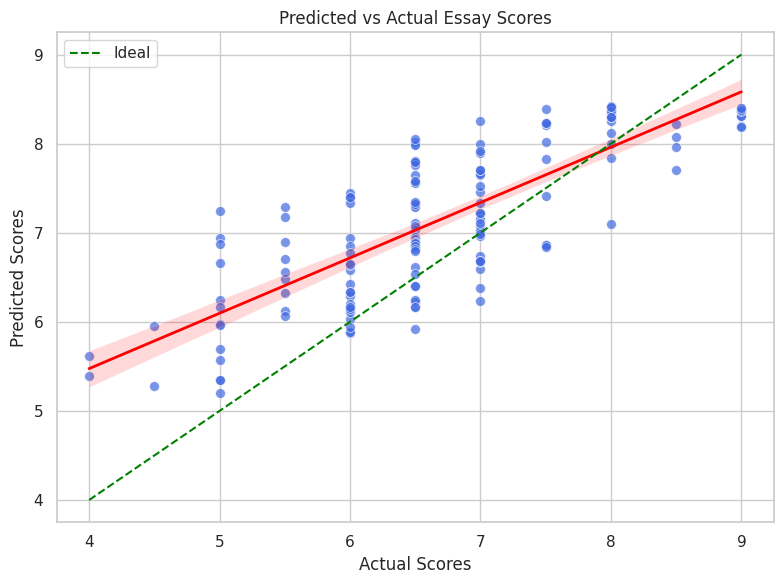

In [ ]:
# Accuracy
preds = trainer.predict(test_dataset)
predicted_scores = preds.predictions.squeeze()
true_scores = np.array(test_labels)

print("MSE:", np.mean((predicted_scores - true_scores) ** 2))
print("MAE:", np.mean(abs(predicted_scores - true_scores)))

# Visualization
y_true = true_scores
y_pred = predicted_scores
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.scatterplot(x=y_true, y=y_pred, color='royalblue', s=50, alpha=0.7)

sns.regplot(x=y_true, y=y_pred, scatter=False, color='red', line_kws={"linewidth": 2})

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='--', label='Ideal')
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Essay Scores")
plt.legend()
plt.tight_layout()
plt.show()


# Top Essay with high error in score prediction

In [ ]:
test_texts = np.array(test_texts)
test_labels = np.array(test_labels)
predicted_scores = np.array(predicted_scores)

errors = np.abs(predicted_scores - test_labels)
N = 5  #top 5
top_error_indices = np.argsort(-errors)[:N]


for idx in top_error_indices:
    print(f"\n--- Example {idx} ---")
    print(f"Essay:\n{test_texts[idx][:500]}{'...' if len(test_texts[idx]) > 500 else ''}")
    print(f"True Score: {test_labels[idx]}")
    print(f"Predicted Score: {predicted_scores[idx]:.2f}")
    print(f"Absolute Error: {errors[idx]:.2f}")



--- Example 0 ---
Essay:
Some people and governments believe in reducing the carbon dioxide of cars and other vehicles is the most effective way to solve the environment problem. Although there are some points also neccesaliry developed except for car and other vehicles, I believe spending the cost of fuel for cars which do not emit detrimental substances play the biggest effect for environmental improvement.
Cars, and other vehicles, such as airplanes are ubiquitous around the world. People rely on most transport type ...
True Score: 5.0
Predicted Score: 7.24
Absolute Error: 2.24

--- Example 10 ---
Essay:
Nowadays, due to a wide range of education methods and systems, there are a lot of opinion and debates for which being the best orientation for students. Some experts believe that it is good for pupil to only focus on a few subjects during their school life. However, some criticisms argue that the more subject students have, the more practical knowledge they can require. For me, bo

# Feedback Generation

In [ ]:
band_feedback = {
    0: "Work on basic grammar and coherence.",
    1: "Improve sentence structure and vocabulary.",
    2: "Focus on organizing ideas and grammar accuracy.",
    3: "Polish coherence and lexical resource.",
    4: "Strong essay. Work on minor improvements for higher precision."
}

def predict_band_and_feedback(essay, model, tokenizer, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()
    model.to(device)

    inputs = tokenizer(essay, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred_class = torch.argmax(outputs.logits, dim=1).item()

    band = ["<5", "5", "6", "7", "8+"][pred_class]
    return band, band_feedback[pred_class]

example_essay = test_texts[0] # first essay in the row
predicted_band, feedback = predict_band_and_feedback(example_essay, model, tokenizer)
print("Predicted Band:", predicted_band)
print("Feedback:", feedback)


Predicted Band: <5
Feedback: Work on basic grammar and coherence.


# New Section